#IMPORT

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# --- ĐỊNH NGHĨA ĐƯỜNG DẪN DỮ LIỆU CỦA BẠN ---
TRAIN_MN_FOLDER = '/content/drive/MyDrive/DATA/fulldataset/MN'
TRAIN_MS_FOLDER = '/content/drive/MyDrive/DATA/fulldataset/MS'
TRAIN_MM_FOLDER = '/content/drive/MyDrive/DATA/fulldataset/MM'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Tải dữ liệu và chuẩn hóa

In [ ]:
# --- HÀM TẢI DỮ LIỆU ---
def load_training_data(mn_folder, ms_folder, mm_folder):
    all_data = []
    all_labels = []

    # Tải dữ liệu dáng đi bình thường (MN)
    print(f"Đang tải dữ liệu từ: {mn_folder}")
    if not os.path.exists(mn_folder):
        print(f"Lỗi: Thư mục {mn_folder} không tồn tại.")
        return np.array([]), np.array([])
    for filename in os.listdir(mn_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(mn_folder, filename)
            df = pd.read_csv(filepath)
            if df.shape == (500, 8):
                all_data.append(df.values)
                all_labels.append(0)  # MN = 0
            else:
                print(f"File {filename} trong thư mục MN không hợp lệ. Bỏ qua.")

    # Tải dữ liệu dáng đi quân sự (MS)
    print(f"Đang tải dữ liệu từ: {ms_folder}")
    if not os.path.exists(ms_folder):
        print(f"Lỗi: Thư mục {ms_folder} không tồn tại.")
        return np.array([]), np.array([])
    for filename in os.listdir(ms_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(ms_folder, filename)
            df = pd.read_csv(filepath)
            if df.shape == (500, 8):
                all_data.append(df.values)
                all_labels.append(1)  # MS = 1
            else:
                print(f"File {filename} trong thư mục MS không hợp lệ. Bỏ qua.")

    # Tải dữ liệu dáng đi khập khiễng (MM)
    print(f"Đang tải dữ liệu từ: {mm_folder}")
    if not os.path.exists(mm_folder):
        print(f"Lỗi: Thư mục {mm_folder} không tồn tại.")
        return np.array([]), np.array([])
    for filename in os.listdir(mm_folder):
        if filename.endswith('.csv'):
            filepath = os.path.join(mm_folder, filename)
            df = pd.read_csv(filepath)
            if df.shape == (500, 8):
                all_data.append(df.values)
                all_labels.append(2)  # MM = 2
            else:
                print(f"File {filename} trong thư mục MM không hợp lệ. Bỏ qua.")

    if not all_data:
        print("Không có dữ liệu hợp lệ nào được tải.")
        return np.array([]), np.array([])

    return np.array(all_data), np.array(all_labels)

# --- TẢI DỮ LIỆU ---
X_train_val_raw, y_train_val = load_training_data(TRAIN_MN_FOLDER, TRAIN_MS_FOLDER, TRAIN_MM_FOLDER)

if X_train_val_raw.size == 0:
    print("Không thể tiếp tục vì không có dữ liệu huấn luyện hợp lệ được tải.")
    exit()

# --- THÔNG TIN DỮ LIỆU ---
print(f"Tổng số chuỗi dữ liệu huấn luyện/xác thực: {X_train_val_raw.shape[0]}")
print(f"Kích thước mỗi chuỗi dữ liệu: {X_train_val_raw.shape[1]} mẫu (thời gian) x {X_train_val_raw.shape[2]} đặc trưng")
print(f"Số nhãn: {y_train_val.shape[0]}")

Đang tải dữ liệu từ: /content/drive/MyDrive/DATA/fulldataset/MN
Đang tải dữ liệu từ: /content/drive/MyDrive/DATA/fulldataset/MS
Đang tải dữ liệu từ: /content/drive/MyDrive/DATA/fulldataset/MM
Tổng số chuỗi dữ liệu huấn luyện/xác thực: 420
Kích thước mỗi chuỗi dữ liệu: 500 mẫu (thời gian) x 8 đặc trưng
Số nhãn: 420


In [ ]:
# Chỉ lấy 6 đặc trưng cảm biến đầu tiên (xac, yac, zac, xang, yang, zang)
X_sensors_train_val = X_train_val_raw[:, :, :6]

# reshape X_sensors_train_val để fit scaler: (tổng_số_mẫu_từ_tất_cả_chuỗi, số_đặc_trưng_cảm_biến)
num_sequences_train_val, num_samples_per_seq, num_features_sensors = X_sensors_train_val.shape
X_reshaped_train_val = X_sensors_train_val.reshape(-1, num_features_sensors)

scaler = StandardScaler()
X_scaled_reshaped_train_val = scaler.fit_transform(X_reshaped_train_val)

# reshape lại về dạng ban đầu sau khi chuẩn hóa
X_processed_train_val = X_scaled_reshaped_train_val.reshape(num_sequences_train_val, num_samples_per_seq, num_features_sensors)

print(f"Hình dạng của X_processed_train_val sau khi chuẩn hóa: {X_processed_train_val.shape}")

# Xem 5 mẫu đầu tiên của chuỗi dữ liệu đầu tiên (đã chuẩn hóa) với tên đặc trưng
feature_names = ['xac', 'yac', 'zac', 'xang', 'yang', 'zang']
df_display = pd.DataFrame(X_processed_train_val[0, :5, :], columns=feature_names)
print("\nXem 5 mẫu đầu tiên của chuỗi dữ liệu đầu tiên (đã chuẩn hóa) với tên đặc trưng:")
print(df_display)

# Chia tập huấn luyện và xác thực (ví dụ 80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X_processed_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

print(f"\nKích thước tập huấn luyện X: {X_train.shape}, y: {y_train.shape}")
print(f"Kích thước tập xác thực X: {X_val.shape}, y: {y_val.shape}")


Hình dạng của X_processed_train_val sau khi chuẩn hóa: (420, 500, 6)

Xem 5 mẫu đầu tiên của chuỗi dữ liệu đầu tiên (đã chuẩn hóa) với tên đặc trưng:
        xac       yac       zac      xang      yang      zang
0 -0.260685  0.246499 -0.917551  0.059849 -0.367416 -0.453924
1 -0.102215  0.272973 -1.073653  0.095089 -0.321627 -0.439162
2 -0.087366  0.301111 -1.124691  0.112709 -0.214415 -0.427476
3 -0.123464  0.289311 -1.139878  0.132091 -0.101619 -0.406564
4 -0.151753  0.299447 -1.228261  0.126805 -0.071465 -0.385036

Kích thước tập huấn luyện X: (336, 500, 6), y: (336,)
Kích thước tập xác thực X: (84, 500, 6), y: (84,)


In [ ]:
# Hiển thị thông tin tổng quát
print(f"\nTổng số chuỗi dữ liệu (train+val): {X_processed_train_val.shape[0]}")
unique_labels, counts = np.unique(y_train_val, return_counts=True)
print("Phân phối nhãn ban đầu (trước chia train/val):")
for label, count in zip(unique_labels, counts):
    print(f"  Nhãn {label}: {count} mẫu")

# Hiển thị một số mẫu chuỗi + nhãn tương ứng
n_samples_to_display = 3
feature_names = ['xac', 'yac', 'zac', 'xang', 'yang', 'zang']

for i in range(n_samples_to_display):
    print(f"\n🟩 Chuỗi thứ {i+1} — Nhãn: {y_train_val[i]}")
    df_display = pd.DataFrame(X_processed_train_val[i, :500, :], columns=feature_names)
    print(df_display)


Tổng số chuỗi dữ liệu (train+val): 420
Phân phối nhãn ban đầu (trước chia train/val):
  Nhãn 0: 140 mẫu
  Nhãn 1: 140 mẫu
  Nhãn 2: 140 mẫu

🟩 Chuỗi thứ 1 — Nhãn: 0
          xac       yac       zac      xang      yang      zang
0   -0.260685  0.246499 -0.917551  0.059849 -0.367416 -0.453924
1   -0.102215  0.272973 -1.073653  0.095089 -0.321627 -0.439162
2   -0.087366  0.301111 -1.124691  0.112709 -0.214415 -0.427476
3   -0.123464  0.289311 -1.139878  0.132091 -0.101619 -0.406564
4   -0.151753  0.299447 -1.228261  0.126805 -0.071465 -0.385036
..        ...       ...       ...       ...       ...       ...
495  0.856414 -0.382379  0.309606  1.205154  1.612661 -1.080060
496  0.619605 -0.221718  0.273755  1.307350  1.618245 -1.012403
497  0.455503 -0.081026  0.214750  1.351401  1.496514 -0.942286
498  0.425677  0.105807  0.244377  1.374307  1.299958 -0.869708
499  0.472399  0.341655  0.243132  1.383117  1.066548 -0.798360

[500 rows x 6 columns]

🟩 Chuỗi thứ 2 — Nhãn: 0
          xac    

#XÂY DỰNG MÔ HÌNH

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional

def build_lstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(units=128, return_sequences=True), input_shape=input_shape),
        Dropout(0.3),
        LSTM(units=64),
        Dropout(0.3),
        Dense(units=32, activation='relu'),
        Dropout(0.2),
        Dense(units=3, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = (num_samples_per_seq, num_features_sensors)
model = build_lstm_model(input_shape)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 500, 256)       │       138,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,595 (869.51 KB)

 Trainable params: 222,595 (869.51 KB)

 Non-trainable params: 0 (0.00 B)

#HUẤN LUYỆN MÔ HÌNH

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping

# Clear session trước khi tạo model mới để tránh giữ mô hình cũ trong bộ nhớ
K.clear_session()

# Xác định input shape
input_shape = (num_samples_per_seq, num_features_sensors)  # (500, 6)

# Xây dựng model mới
model = build_lstm_model(input_shape)

# Tạo callback dừng sớm nếu val_loss không giảm sau 10 epoch
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.3271 - loss: 1.1042 - val_accuracy: 0.4286 - val_loss: 1.0675
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.4728 - loss: 1.0539 - val_accuracy: 0.4405 - val_loss: 1.0309
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5868 - loss: 0.9694 - val_accuracy: 0.5476 - val_loss: 0.9452
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.6504 - loss: 0.8425 - val_accuracy: 0.6190 - val_loss: 0.8559
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.7231 - loss: 0.7184 - val_accuracy: 0.6667 - val_loss: 0.7493
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.7261 - loss: 0.6758 - val_accuracy: 0.7857 - val_loss: 0.5526
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.8695 - loss: 0.4530 - val_accuracy: 0.5357 - val_loss: 1.1544
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.5422 - loss: 1.0247 - val_accuracy: 0.

In [ ]:
model.save("lstm_model.h5")

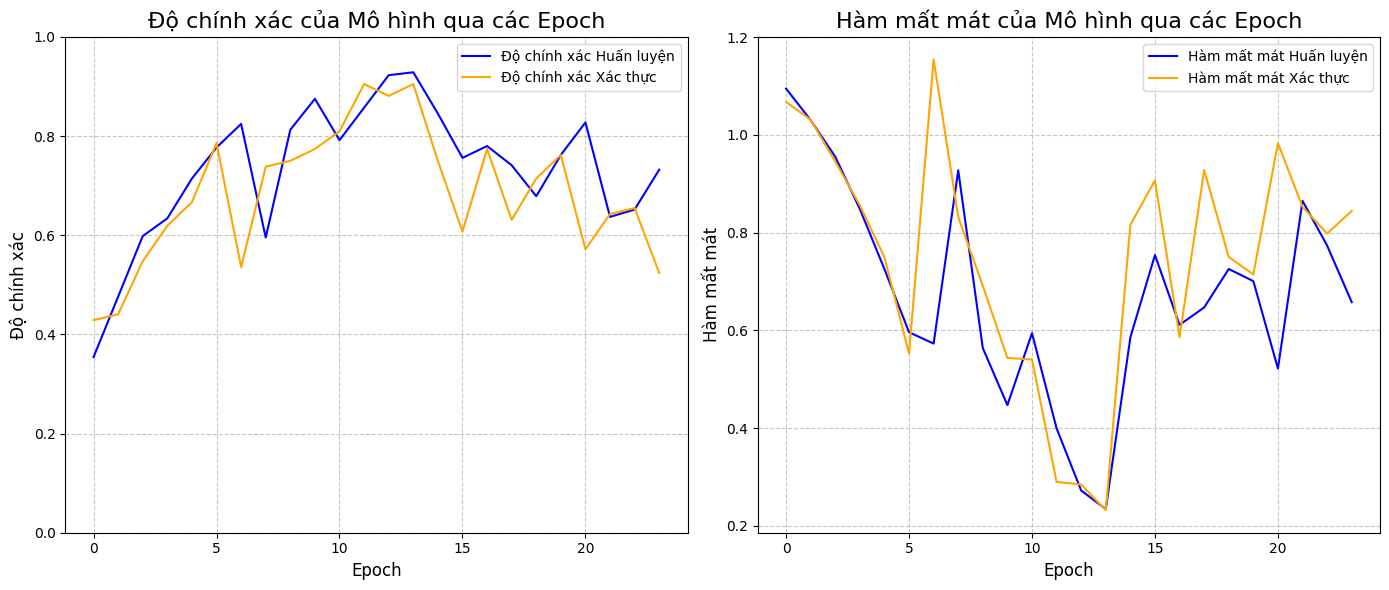

In [ ]:
# --- Vẽ đồ thị lịch sử huấn luyện ---

plt.figure(figsize=(14, 6)) # Thiết lập kích thước tổng thể của figure

# Đồ thị Độ chính xác (Accuracy)
plt.subplot(1, 2, 1) # Tạo subplot 1 hàng, 2 cột, ở vị trí 1
plt.plot(history.history['accuracy'], label='Độ chính xác Huấn luyện', color='blue')
plt.plot(history.history['val_accuracy'], label='Độ chính xác Xác thực', color='orange')
plt.title('Độ chính xác của Mô hình qua các Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Độ chính xác', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim([0, 1]) # Đặt giới hạn trục Y từ 0 đến 1 cho độ chính xác

# Đồ thị Hàm mất mát (Loss)
plt.subplot(1, 2, 2) # Tạo subplot 1 hàng, 2 cột, ở vị trí 2
plt.plot(history.history['loss'], label='Hàm mất mát Huấn luyện', color='blue')
plt.plot(history.history['val_loss'], label='Hàm mất mát Xác thực', color='orange')
plt.title('Hàm mất mát của Mô hình qua các Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Hàm mất mát', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
# Hàm mất mát không có giới hạn trên cố định, nên không đặt ylim cứng

plt.tight_layout() # Tự động điều chỉnh khoảng cách giữa các subplot
plt.show() # Hiển thị đồ thị

#KIỂM THỬ

In [ ]:
TEST_MN_FOLDER = '/content/drive/MyDrive/DATA/thi/MN'
TEST_MS_FOLDER = '/content/drive/MyDrive/DATA/thi/MS'
TEST_MM_FOLDER = '/content/drive/MyDrive/DATA/thi/MM'


In [ ]:
def load_test_data(mn_folder, ms_folder, mm_folder, scaler):
    all_data = []
    all_labels = []

    # MN test
    if not os.path.exists(mn_folder):
        print(f"Lỗi: Thư mục {mn_folder} không tồn tại.")
        return np.array([]), np.array([])
    for filename in os.listdir(mn_folder):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(mn_folder, filename))
            if df.shape == (500, 8):
                all_data.append(df.values)
                all_labels.append(0)
            else:
                print(f"File {filename} trong MN test không hợp lệ, bỏ qua.")

    # MS test
    if not os.path.exists(ms_folder):
        print(f"Lỗi: Thư mục {ms_folder} không tồn tại.")
        return np.array([]), np.array([])
    for filename in os.listdir(ms_folder):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(ms_folder, filename))
            if df.shape == (500, 8):
                all_data.append(df.values)
                all_labels.append(1)
            else:
                print(f"File {filename} trong MS test không hợp lệ, bỏ qua.")

    # MM test
    if not os.path.exists(mm_folder):
        print(f"Lỗi: Thư mục {mm_folder} không tồn tại.")
        return np.array([]), np.array([])
    for filename in os.listdir(mm_folder):
        if filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(mm_folder, filename))
            if df.shape == (500, 8):
                all_data.append(df.values)
                all_labels.append(2)
            else:
                print(f"File {filename} trong MM test không hợp lệ, bỏ qua.")

    if not all_data:
        print("Không có dữ liệu test hợp lệ.")
        return np.array([]), np.array([])

    all_data = np.array(all_data)
    all_labels = np.array(all_labels)

    # Lấy 6 đặc trưng cảm biến đầu tiên
    X_sensors = all_data[:, :, :6]

    # Chuẩn hóa dữ liệu test với scaler của train
    num_sequences, num_samples, num_features = X_sensors.shape
    X_reshaped = X_sensors.reshape(-1, num_features)
    X_scaled_reshaped = scaler.transform(X_reshaped)
    X_processed = X_scaled_reshaped.reshape(num_sequences, num_samples, num_features)

    return X_processed, all_labels


In [ ]:
# Load test data
X_test, y_test = load_test_data(TEST_MN_FOLDER, TEST_MS_FOLDER, TEST_MM_FOLDER, scaler)

if X_test.size == 0:
    print("Không có dữ liệu test hợp lệ để đánh giá.")
else:
    print(f"Số mẫu test: {X_test.shape[0]}")
    print(f"Kích thước mỗi chuỗi test: {X_test.shape[1]} x {X_test.shape[2]}")

    # Đánh giá model trên tập test
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
    print(f"\nĐộ chính xác trên tập test: {test_acc:.4f}")
    print(f"Loss trên tập test: {test_loss:.4f}")

    # Dự đoán nhãn test để xem chi tiết
    y_pred_prob = model.predict(X_test)
    y_pred = y_pred_prob.argmax(axis=1)

    # Báo cáo chi tiết
    from sklearn.metrics import classification_report, confusion_matrix
    print("\nBáo cáo phân loại:\n", classification_report(y_test, y_pred))
    print("\nMa trận nhầm lẫn:\n", confusion_matrix(y_test, y_pred))


Số mẫu test: 60
Kích thước mỗi chuỗi test: 500 x 6
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9139 - loss: 0.3637

Độ chính xác trên tập test: 0.9333
Loss trên tập test: 0.3011
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 302ms/step

Báo cáo phân loại:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89        20
           1       0.95      1.00      0.98        20
           2       0.87      1.00      0.93        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60


Ma trận nhầm lẫn:
 [[16  1  3]
 [ 0 20  0]
 [ 0  0 20]]


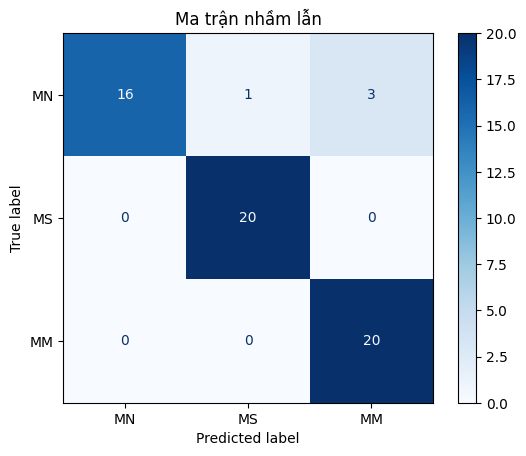

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Tên các lớp (labels)
class_names = ['MN', 'MS', 'MM']

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)

# Vẽ ma trận nhầm lẫn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)

plt.title("Ma trận nhầm lẫn")
plt.show()
